# Test

## Start test

In [ ]:
! wget https://bark.phon.ioc.ee/voxlingua107/zip_urls.txt
! cat zip_urls.txt |  parallel -j 4 wget --continue

--2023-06-27 05:58:10--  https://bark.phon.ioc.ee/voxlingua107/zip_urls.txt
Resolving bark.phon.ioc.ee (bark.phon.ioc.ee)... 193.40.251.129
Connecting to bark.phon.ioc.ee (bark.phon.ioc.ee)|193.40.251.129|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4819 (4.7K) [text/plain]
Saving to: ‘zip_urls.txt’

zip_urls.txt        100%[===================>]   4.71K  --.-KB/s    in 0s      

2023-06-27 05:58:11 (169 MB/s) - ‘zip_urls.txt’ saved [4819/4819]



In [ ]:
import numpy as np
import pandas as pd
def write_file(name):
    df = pd.DataFrame(data = [[1,2],[3,4],[5,6]],
    columns = ['col-one', 'col-two'])
    df.to_csv(name+'.csv')


In [ ]:
temp_list= np.array(["hello","hi","file1"])
[write_file(x) for x in temp_list]

[None, None, None]

In [ ]:
def create_spect(filename,name, is_train=True):
    plt.interactive(False)
    clip, sample_rate = librosa.load(filename, sr=None)
    fig = plt.figure(figsize=[0.72,0.72])
    ax = fig.add_subplot(111)
    #ax.axes.get_xaxis().set_visible(False)
    #ax.axes.get_yaxis().set_visible(False)
    ax.set_frame_on(False)
    S = librosa.feature.melspectrogram(y=clip, sr=sample_rate)
    #S = librosa.feature.mfcc(y=clip, sr=sample_rate)
    librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
    prefix= TRAIN_IMG_PATH
    if not is_train:
        prefix= TEST_IMG_PATH
    filename  = prefix + name
    plt.savefig(filename, dpi=400, bbox_inches='tight',pad_inches=0)
    plt.close()
    fig.clf()
    plt.close(fig)
    plt.close('all')
    del filename,name,clip,sample_rate,fig,ax,S

In [ ]:
def just_spec(filename, name, is_train=True):
    plt.interactive(False)
    matplotlib.use('Agg')
    data, samplerate = sf.read(filename)
    #freq, time, Sxx = signal.spectrogram(data, samplerate, scaling='spectrum')
    #plt.pcolormesh(time, freq, Sxx)
    Pxx, freqs, bins, im = plt.specgram(data, Fs=samplerate)
    ax = plt.gca()
    #fig = plt.gcf()
    ax.axis("off")
    prefix= TRAIN_IMG_PATH
    if not is_train:
        prefix= TEST_IMG_PATH
    filename  = prefix + name
    plt.savefig(filename, dpi=400, bbox_inches='tight',pad_inches=0)

In [ ]:
import soundfile as sf
import scipy.signal as signal
import matplotlib
from PIL import Image
import io
plt.interactive(False)
import timeit
start= [0]*20
end= [0]*20
cnt=0
def upd_time():
    global cnt
    end[cnt]=timeit.default_timer()
    cnt=cnt+1
    start[cnt]=timeit.default_timer()

def create_greenspec(filename, name, is_train=True):
    global cnt
    cnt=0
    upd_time()
    #plt.interactive(False)
    matplotlib.use('Agg')
    upd_time()
    data, samplerate = sf.read(filename)
    #freq, time, Sxx = signal.spectrogram(data, samplerate, scaling='spectrum')
    #plt.pcolormesh(time, freq, Sxx)
    upd_time()
    Pxx, freqs, bins, im = plt.specgram(data, Fs=samplerate)
    upd_time()
    ax = plt.gca()
    upd_time()
    fig = plt.gcf()
    upd_time()
    ax.axis("off")
    upd_time()
    prefix= TRAIN_IMG_PATH
    upd_time()
    if not is_train:
        prefix= TEST_IMG_PATH
    upd_time()
    filename  = prefix + name
    upd_time()
    #plt.savefig(filename, dpi=400, bbox_inches='tight',pad_inches=0)
    #upd_time()

    #return
    buf = io.BytesIO()
    fig.canvas.print_jpg(buf)
    buf.seek(0)
    plot_image = Image.open(buf)


    upd_time()
    # Render the plot to a PIL image
    #plot_image = Image.frombytes('RGB', canvas.get_width_height(), canvas.tostring_rgb())
    #upd_time()
    plot_image.save(filename)
    upd_time()
    # Close the plot and PIL image
    #plt.close(fig)
    #upd_time()
    #plot_image.close()

In [ ]:
%%time
#for file in train_data_dir[i:i+train_size]:
#    name = file.split('/')[-1]
#    train_id.append(name+".jpg")
#    create_spectrogram(file,name)

traindf = pd.DataFrame(train_data_dir[0:10],columns = ['file'])
traindf['ID']= traindf['file'].apply(lambda x: x.split('/')[-1]+'.jpg')
#traindf.apply(lambda x: create_spectrogram(x.file, x.ID), axis=1)
np.vectorize(just_spec)(traindf['file'], traindf['ID'])
traindf

LibsndfileError: ignored

In [ ]:
how = [end[i]-start[i] for i in range(20)]
print(how)

[6624.770487622, 4.377999994176207e-05, 0.011670042000332614, 0.02217329100039933, 5.486000191012863e-06, 2.04900061362423e-06, 2.3611999495187774e-05, 1.8509999790694565e-06, 4.060002538608387e-07, 1.4940005712560378e-06, 0.9924033429997507, 0.0007784659992466914, -6625.797607543, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
!cp $TRAIN_IMG_PATH $DRIVE_PATH -r

In [ ]:
print("done")

In [ ]:
traindf

,file,ID
0,/content/train/train/en_f_386ee651f6f1539ff562...,en_f_386ee651f6f1539ff5622c55e234e5a4.fragment...
1,/content/train/train/es_f_53b555eab2b3baada380...,es_f_53b555eab2b3baada380f7d3ede20b20.fragment...
2,/content/train/train/es_m_534a0cf6f6aea8e35667...,es_m_534a0cf6f6aea8e35667a9147d2d0f8d.fragment...
3,/content/train/train/de_m_df90bffac026f705f4a9...,de_m_df90bffac026f705f4a99871d71684f1.fragment...
4,/content/train/train/en_m_61764486dd621ce03fa4...,en_m_61764486dd621ce03fa461e92cd9e2b3.fragment...
...,...,...
95,/content/train/train/en_f_10134f409d9b7b0b95fe...,en_f_10134f409d9b7b0b95fed6e025febcad.fragment...
96,/content/train/train/de_m_df90bffac026f705f4a9...,de_m_df90bffac026f705f4a99871d71684f1.fragment...
97,/content/train/train/es_m_d5b91a4ffb1ead826b79...,es_m_d5b91a4ffb1ead826b7968ec19cbfa1c.fragment...
98,/content/train/train/es_f_bac9be13a058d1c859ed...,es_f_bac9be13a058d1c859ed5d2e3a0dc27b.fragment...


In [ ]:
print(traindf.ID[0])
print(traindf.file[0])

es_m_b8e0e6f56f02e6f8f79cc360958e5982.fragment25.speed6.flac.jpg
/content/train/train/es_m_b8e0e6f56f02e6f8f79cc360958e5982.fragment25.speed6.flac


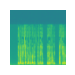

In [ ]:
create_greenspec(train_data_dir[0], 'that.jpg')

/content/train/train/en_f_386ee651f6f1539ff5622c55e234e5a4.fragment5.speed1.flac


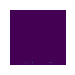

In [ ]:
import numpy as np
import soundfile as sf
import scipy.signal as signal
import matplotlib.pyplot as plt


print(train_data_dir[0])
data, samplerate = sf.read(train_data_dir[0])
freq, time, Sxx = signal.spectrogram(data, samplerate, scaling='spectrum')
plt.pcolormesh(time, freq, Sxx)

#fig = plt.figure(figsize=[0.72,0.72])
#ax = fig.add_subplot(111)
#ax.axes.get_xaxis().set_visible(False)
#ax.axes.get_yaxis().set_visible(False)

ax = plt.gca()

#hide x-axis
#ax.get_xaxis().set_visible(False)
#ax.get_yaxis().set_visible(False)

#hide y-axis
#ax.set_frame_on(False)
ax.axis("off")
# add axis labels
#plt.ylabel('Frequency [Hz]')
#plt.xlabel('Time [sec]')
plt.savefig("./this.jpg", dpi=400, bbox_inches='tight',pad_inches=0)
plt.show()

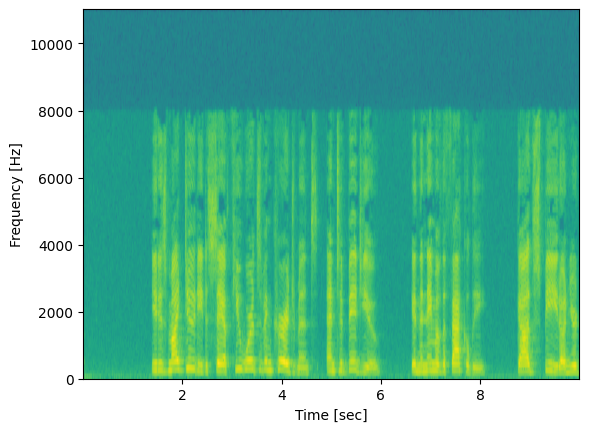

In [ ]:
Pxx, freqs, bins, im = plt.specgram(data, Fs=samplerate)

# add axis labels
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

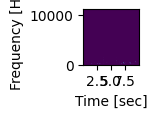

In [ ]:
import numpy as np
import soundfile as sf
import scipy.signal as signal
import matplotlib.pyplot as plt


data, samplerate = sf.read("./audio.flac")
freq, time, Sxx = signal.spectrogram(data, samplerate, scaling='spectrum')
plt.pcolormesh(time, freq, Sxx)

# add axis labels
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')

plt.show() #added second time

In [ ]:

Pxx, freqs, bins, im = plt.specgram(data, Fs=samplerate)

# add axis labels
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')

Text(0.5, 0, 'Time [sec]')

## End Test


## dangerous remove

In [ ]:
remove_dir=np.array(glob(DRIVE_PATH+"en*.npy")
print(remove_dir)

# Run

## check GPU availabilty

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

''

In [ ]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Number of GPUs Available: ", len(physical_devices))
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

Number of GPUs Available:  0


## Paths

In [ ]:
CUR_DIR = '/content/' #this may be different runnig local
MAT_DIR= CUR_DIR+'mat/'
TRAIN_MAT_PATH = MAT_DIR + 'train/train/'
TEST_MAT_PATH = MAT_DIR + 'test/test/'
VOICE_DIR = CUR_DIR+'voice/'
TRAIN_VOICE_PATH = VOICE_DIR+'train/train/'
TEST_VOICE_PATH = VOICE_DIR+'test/test/'
DRIVE_PATH = CUR_DIR+'drive/MyDrive/Bachelor_Project/'
DRIVE2_PATH = CUR_DIR+'drive/MyDrive/Bachelor_Project_Part2/'
DRIVE3_PATH = CUR_DIR+'drive/MyDrive/Bachelor_Project_Part3/'
#TRAIN_VOICE_OLD_PATH = CUR_DIR+'train/train/'
#TEST_VOICE_OLD_PATH = CUR_DIR+'test/test/'
#TRAIN_IMG_PATH = CUR_DIR+'train/train-img/'
#TEST_IMG_PATH = CUR_DIR+'test/test-img/'
TRAIN_MAT_PATH = MAT_DIR + 'train/'
TEST_MAT_PATH = MAT_DIR + 'test/'
MOZILLA_PATH= CUR_DIR+'mozilla/'
MOZILLA_VALID_TRAIN = CUR_DIR+'mozilla/cv-valid-train/'
MOZILLA_VALID_DEV = CUR_DIR+'mozilla/cv-valid-dev/'
MOZILLA_VALID_TEST = CUR_DIR+'mozilla/cv-valid-test/'

In [ ]:
! mkdir $MAT_DIR
! mkdir $VOICE_DIR
! mkdir $TRAIN_MAT_PATH
! mkdir $TEST_MAT_PATH

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## mount google drive

In [ ]:
from google.colab import drive
drive.mount(CUR_DIR+'drive/', force_remount=True)
#%cd '{CUR_DIR}drive/MyDrive/Bachelor_Project/'
#%ls

Mounted at /content/drive/


## import libraries



In [ ]:
# low import
import numpy as np
import pandas as pd
import gc

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from glob import glob
import librosa
import librosa.display
import soundfile as sf
import scipy.signal as signal
import gc
import shutil

## Load Dataset from kaggle

In [ ]:
!pip install kaggle

In [ ]:
#! mkdir ~/.kaggle
#! cp kaggle.json ~/.kaggle/
#! chmod 600 ~/.kaggle/kaggle.json
#! kaggle datasets download mozillaorg/common-voice

In [ ]:
#!unzip {CUR_DIR}common-voice.zip

## spoken-language-identification dataset


In [ ]:
! mkdir ~/.kaggle
! cp $DRIVE_PATH/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download toponowicz/spoken-language-identification

100% 14.9G/14.9G [03:45<00:00, 66.5MB/s]
100% 14.9G/14.9G [03:45<00:00, 70.9MB/s]


In [ ]:
%%capture
!unzip {CUR_DIR}spoken-language-identification.zip -d $VOICE_DIR

In [ ]:
! mkdir $CUR_DIR/train
! mkdir $CUR_DIR/test

In [ ]:
! mv $TRAIN_VOICE_PATH $TRAIN_VOICE_OLD_PATH
! mv $TEST_VOICE_PATH $TEST_VOICE_OLD_PATH

In [ ]:
!mkdir $TRAIN_IMG_PATH
!mkdir $TEST_IMG_PATH

mkdir: missing operand
Try 'mkdir --help' for more information.
mkdir: missing operand
Try 'mkdir --help' for more information.


## Mozilla Dataset

In [ ]:
! kaggle datasets download mozillaorg/common-voice

In [ ]:
!mkdir mozilla

In [ ]:
%%capture
!unzip {CUR_DIR}common-voice.zip -d $MOZILLA_PATH

### remove invalid and other datasets

In [ ]:
!rm $MOZILLA_PATH/LICENSE.txt
!rm $MOZILLA_PATH/README.txt
!rm -r $MOZILLA_PATH/cv-other*
!rm -r $MOZILLA_PATH/cv-invalid*

In [ ]:
valid_train_df = pd.read_csv(MOZILLA_PATH+"cv-valid-train.csv")
valid_train_df

In [ ]:
valid_dev_df = pd.read_csv(MOZILLA_PATH+"cv-valid-dev.csv")
valid_dev_df

In [ ]:
valid_test_df = pd.read_csv(MOZILLA_PATH+"cv-valid-test.csv")
valid_test_df

In [ ]:
def process_mozilla_df(df, path_type):
    #df = df[pd.notnull(df['accent'])]
    df.dropna(subset=['accent'], inplace=True)
    df.rename(columns={'filename': 'file', 'accent': 'lang'}, inplace=True)
    df['ID'] = df['file'].str.split('/', expand=True)[1] + '.npy'
    df['file'] = path_type+df['file']

In [ ]:
process_mozilla_df(valid_train_df, MOZILLA_VALID_TRAIN)
process_mozilla_df(valid_dev_df, MOZILLA_VALID_DEV)
process_mozilla_df(valid_test_df, MOZILLA_VALID_TEST)

In [ ]:
valid_train_df

,file,text,up_votes,down_votes,age,gender,lang,duration,ID
5,/content/mozilla/cv-valid-train/cv-valid-train...,a shepherd may like to travel but he should ne...,1,0,twenties,female,us,NaN,sample-000005.mp3.jpg
8,/content/mozilla/cv-valid-train/cv-valid-train...,put jackie right on the staff,3,0,seventies,male,us,NaN,sample-000008.mp3.jpg
13,/content/mozilla/cv-valid-train/cv-valid-train...,but he had found a guide and didn't want to mi...,1,0,thirties,female,us,NaN,sample-000013.mp3.jpg
14,/content/mozilla/cv-valid-train/cv-valid-train...,as they began to decorate the hallway a silhou...,1,0,sixties,male,england,NaN,sample-000014.mp3.jpg
19,/content/mozilla/cv-valid-train/cv-valid-train...,then they got ahold of some dough and went goofy,1,0,fifties,male,australia,NaN,sample-000019.mp3.jpg
...,...,...,...,...,...,...,...,...,...
195766,/content/mozilla/cv-valid-train/cv-valid-train...,but before i go i want to tell you a little story,1,0,fourties,male,england,NaN,sample-195766.mp3.jpg
195767,/content/mozilla/cv-valid-train/cv-valid-train...,down below in the darkness were hundreds of pe...,3,0,thirties,female,us,NaN,sample-195767.mp3.jpg
195770,/content/mozilla/cv-valid-train/cv-valid-train...,he heard a muffled grating sound and saw the b...,4,0,twenties,male,england,NaN,sample-195770.mp3.jpg
195771,/content/mozilla/cv-valid-train/cv-valid-train...,the englishman said nothing,1,0,thirties,male,england,NaN,sample-195771.mp3.jpg


In [ ]:
valid_dev_df

,file,text,up_votes,down_votes,age,gender,lang,duration,ID
4,/content/mozilla/cv-valid-dev/cv-valid-dev/sam...,he moved about invisible but everyone could he...,1,0,fourties,female,england,NaN,sample-000004.mp3.jpg
5,/content/mozilla/cv-valid-dev/cv-valid-dev/sam...,but everything had changed,3,0,teens,male,us,NaN,sample-000005.mp3.jpg
8,/content/mozilla/cv-valid-dev/cv-valid-dev/sam...,the shop folks were taking down their shutters...,1,0,twenties,female,canada,NaN,sample-000008.mp3.jpg
9,/content/mozilla/cv-valid-dev/cv-valid-dev/sam...,the teacher thought that he'd taught himself a...,1,0,fifties,female,australia,NaN,sample-000009.mp3.jpg
13,/content/mozilla/cv-valid-dev/cv-valid-dev/sam...,in those days very few of the people had any i...,5,0,twenties,male,us,NaN,sample-000013.mp3.jpg
...,...,...,...,...,...,...,...,...,...
4053,/content/mozilla/cv-valid-dev/cv-valid-dev/sam...,if you start your emails with greetings let me...,1,0,sixties,female,canada,NaN,sample-004053.mp3.jpg
4055,/content/mozilla/cv-valid-dev/cv-valid-dev/sam...,the atmosphere was suffused with the sweet sce...,4,1,fourties,male,england,NaN,sample-004055.mp3.jpg
4067,/content/mozilla/cv-valid-dev/cv-valid-dev/sam...,they reached the center of a large plaza where...,3,0,fourties,female,us,NaN,sample-004067.mp3.jpg
4069,/content/mozilla/cv-valid-dev/cv-valid-dev/sam...,no sense messing up the streets,2,0,thirties,male,england,NaN,sample-004069.mp3.jpg


In [ ]:
valid_test_df

,file,text,up_votes,down_votes,age,gender,lang,duration,ID
3,/content/mozilla/cv-valid-test/cv-valid-test/s...,down below in the darkness were hundreds of pe...,4,0,twenties,male,us,NaN,sample-000003.mp3.jpg
5,/content/mozilla/cv-valid-test/cv-valid-test/s...,down below in the darkness were hundreds of pe...,4,1,twenties,male,us,NaN,sample-000005.mp3.jpg
8,/content/mozilla/cv-valid-test/cv-valid-test/s...,this was the strangest of all things that ever...,1,0,thirties,male,england,NaN,sample-000008.mp3.jpg
9,/content/mozilla/cv-valid-test/cv-valid-test/s...,it was glaringly hot not a cloud in the sky no...,3,0,fifties,male,us,NaN,sample-000009.mp3.jpg
14,/content/mozilla/cv-valid-test/cv-valid-test/s...,follow the instructions here,1,0,twenties,male,scotland,NaN,sample-000014.mp3.jpg
...,...,...,...,...,...,...,...,...,...
3971,/content/mozilla/cv-valid-test/cv-valid-test/s...,he's on my phone,1,0,teens,male,england,NaN,sample-003971.mp3.jpg
3975,/content/mozilla/cv-valid-test/cv-valid-test/s...,the planet's core is made of solid gold but ev...,1,0,twenties,male,us,NaN,sample-003975.mp3.jpg
3976,/content/mozilla/cv-valid-test/cv-valid-test/s...,we've got her located,1,0,thirties,male,england,NaN,sample-003976.mp3.jpg
3980,/content/mozilla/cv-valid-test/cv-valid-test/s...,i've got to see nicole right away,1,0,fifties,male,australia,NaN,sample-003980.mp3.jpg


## Managing dataset

### Load datasets

In [ ]:
first_half_df = pd.read_csv(DRIVE_PATH + "first_half.csv")

In [ ]:
first_half_df

,file,ID,lang
0,/content/voice/train/train/de_m_df90bffac026f7...,de_m_df90bffac026f705f4a99871d71684f1.fragment...,de
1,/content/voice/train/train/de_m_0345d503166fbc...,de_m_0345d503166fbcb125b6e10e2e804443.fragment...,de
2,/content/voice/train/train/en_m_d2f13c7f37ecec...,en_m_d2f13c7f37ecec67df0f46408c224bc1.fragment...,en
3,/content/voice/train/train/en_m_3a8f30bef6d7b6...,en_m_3a8f30bef6d7b6a1332629491eabcbf0.fragment...,en
4,/content/voice/train/train/en_f_7701e10392ce7b...,en_f_7701e10392ce7bcfba6d2fcca56fb8d9.fragment...,en
...,...,...,...
36535,/content/voice/train/train/de_f_26ddc4e756f612...,de_f_26ddc4e756f61233d74d42cc000c9dae.fragment...,de
36536,/content/voice/train/train/en_m_17b5d499519197...,en_m_17b5d4995191976232356345dfbb82cb.fragment...,en
36537,/content/voice/train/train/es_f_56ef0bde6c92a0...,es_f_56ef0bde6c92a0100da23cdd39a8a112.fragment...,es
36538,/content/voice/train/train/es_f_cc86b9208b120f...,es_f_cc86b9208b120f1f147a9246ab39f5e4.fragment...,es


In [ ]:
print(len(first_half_df[first_half_df['lang']  == 'en']))
print(len(first_half_df[first_half_df['lang']  == 'es']))
print(len(first_half_df[first_half_df['lang']  == 'de']))

12163
12200
12177


In [ ]:
print(first_half_df["ID"].iloc[1])

de_m_0345d503166fbcb125b6e10e2e804443.fragment25.speed4.npy


In [ ]:
%%time
format_len = len('flac')
np.vectorize(spectrogram_mat)(TRAIN_VOICE_PATH, first_half_df['ID'], TRAIN_MAT_PATH)

CPU times: user 36min 28s, sys: 26min 53s, total: 1h 3min 22s
Wall time: 41min


array([None, None, None, ..., None, None, None], dtype=object)

In [ ]:
! du -sh $TRAIN_MAT_PATH

7.6G	/content/mat/train/


In [ ]:
! rm -r $VOICE_DIR

In [ ]:
! mkdir {DRIVE3_PATH}first_half

In [ ]:
first_half_df.apply(lambda x: shutil.copy(TRAIN_MAT_PATH+x.ID, DRIVE3_PATH+"first_half/"+x.ID), axis=1)

0        /content/drive/MyDrive/Bachelor_Project_Part3/...
1        /content/drive/MyDrive/Bachelor_Project_Part3/...
2        /content/drive/MyDrive/Bachelor_Project_Part3/...
3        /content/drive/MyDrive/Bachelor_Project_Part3/...
4        /content/drive/MyDrive/Bachelor_Project_Part3/...
                               ...                        
36535    /content/drive/MyDrive/Bachelor_Project_Part3/...
36536    /content/drive/MyDrive/Bachelor_Project_Part3/...
36537    /content/drive/MyDrive/Bachelor_Project_Part3/...
36538    /content/drive/MyDrive/Bachelor_Project_Part3/...
36539    /content/drive/MyDrive/Bachelor_Project_Part3/...
Length: 36540, dtype: object

In [ ]:
first_half_df['lang'] = first_half_df['ID'].apply(lambda x: x.split('_')[0])

In [ ]:
first_half_df.to_csv(DRIVE_PATH+"first_half.csv")

In [ ]:
testdf

,file,ID
0,/content/voice/test/test/en_f_67a0cba10d171b24...,en_f_67a0cba10d171b24039a79faa1d4d603.fragment...
1,/content/voice/test/test/en_m_b74b2bf2af570393...,en_m_b74b2bf2af570393cae91f4ed89cece7.fragment...
2,/content/voice/test/test/es_f_50298ab71aaba850...,es_f_50298ab71aaba8508ebeef49d853df11.fragment...
3,/content/voice/test/test/de_f_63f5b79c76cf5a1a...,de_f_63f5b79c76cf5a1a4bbd1c40f54b166e.fragment...
4,/content/voice/test/test/en_f_67a0cba10d171b24...,en_f_67a0cba10d171b24039a79faa1d4d603.fragment...
...,...,...
535,/content/voice/test/test/de_m_923551d571cc4373...,de_m_923551d571cc437382d0294dda2dd0aa.fragment...
536,/content/voice/test/test/en_m_b74b2bf2af570393...,en_m_b74b2bf2af570393cae91f4ed89cece7.fragment...
537,/content/voice/test/test/en_m_b74b2bf2af570393...,en_m_b74b2bf2af570393cae91f4ed89cece7.fragment...
538,/content/voice/test/test/de_m_923551d571cc4373...,de_m_923551d571cc437382d0294dda2dd0aa.fragment...


In [ ]:
testdf['lang'] = testdf['ID'].apply(lambda x: x.split('_')[0])

In [ ]:
testdf.to_csv(DRIVE_PATH+"testdf.csv")

In [ ]:
%%time
format_len = len('flac')
testdf = pd.DataFrame(test_data_dir,columns = ['file'])
testdf['ID']= testdf['file'].apply(lambda x: x.split('/')[-1][:-format_len]+'npy')
np.vectorize(spectrogram_mat)(TEST_VOICE_PATH, testdf['ID'], TEST_MAT_PATH)
testdf

### Move to label directory

In [ ]:
labels = ['en','es','de']
for x in labels:
    !mkdir $TRAIN_IMG_PATH/$x
    !mkdir $TEST_IMG_PATH/$x

In [ ]:
def move_to_label(name,lang, is_train=True):
    prefix= TRAIN_IMG_PATH
    if not is_train:
        prefix= TEST_IMG_PATH
    shutil.move(prefix+name,prefix+lang+"/"+name)
    #print(prefix+name, "to", prefix+lang+"/"+name)

In [ ]:
train_data_dir=np.array(glob(TRAIN_VOICE_PATH+"*"))
test_data_dir=np.array(glob(TEST_VOICE_PATH+"*"))

In [ ]:
train_data_dir

array(['/content/voice/train/train/de_m_df90bffac026f705f4a99871d71684f1.fragment28.noise3.flac',
       '/content/voice/train/train/en_f_9a47e3d56398b8108f59385aab8bbe87.fragment21.pitch5.flac',
       '/content/voice/train/train/de_f_2825fa225d6ca4800f0cf0504b76ca65.fragment14.speed6.flac',
       ...,
       '/content/voice/train/train/es_f_68e1dcf1b41edcfa24b402f46ec2a65e.fragment2.speed7.flac',
       '/content/voice/train/train/de_m_3aa01c55ba7ca85cad2977c848eb826f.fragment8.noise6.flac',
       '/content/voice/train/train/de_m_fc6bd6bb9d66a89bb8d8a8a7efa23e6b.fragment9.speed8.flac'],
      dtype='<U88')

In [ ]:
print(len(train_data_dir))

73080


In [ ]:
print(len(test_data_dir))

540


## Create spectogram

### failed spectrograms:

In [ ]:
train_size= 10000
test_size= 100
print("before: ", plt.rcParams['figure.figsize'])
plt.rcParams['figure.figsize'] = (0.72, 0.72)
print("after: ", plt.rcParams['figure.figsize'])

before:  [0.72, 0.72]
after:  [0.72, 0.72]


In [ ]:
def create_spectrogram(filename,name, is_train=True):
    plt.interactive(False)
    clip, sample_rate = librosa.load(filename, sr=None)
    fig = plt.figure(figsize=[0.72,0.72])
    ax = fig.add_subplot(111)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_frame_on(False)
    S = librosa.feature.melspectrogram(y=clip, sr=sample_rate)
    #S = librosa.feature.mfcc(y=clip, sr=sample_rate)
    librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
    prefix= TRAIN_IMG_PATH
    if not is_train:
        prefix= TEST_IMG_PATH
    filename  = prefix + name
    plt.savefig(filename, dpi=400, bbox_inches='tight',pad_inches=0)
    plt.close()
    fig.clf()
    plt.close(fig)
    plt.close('all')
    del filename,name,clip,sample_rate,fig,ax,S

In [ ]:
def just_spec(filename, name, is_train=True):
    plt.interactive(False)
    matplotlib.use('Agg')
    data, samplerate = sf.read(filename)
    Pxx, freqs, bins, im = plt.specgram(data, Fs=samplerate)
    ax = plt.gca()
    ax.axis("off")
    prefix= TRAIN_IMG_PATH
    if not is_train:
        prefix= TEST_IMG_PATH
    filename  = prefix + name
    plt.savefig(filename, dpi=400, bbox_inches='tight',pad_inches=0)

In [ ]:
def spectrogram_mat(filename, file, is_train=True):
    #plt.interactive(False)
    clip, sample_rate = librosa.load(filename, sr=None)
    #fig = plt.figure(figsize=[0.72,0.72])
    #ax = fig.add_subplot(111)
    #ax.axes.get_xaxis().set_visible(False)
    #ax.axes.get_yaxis().set_visible(False)
    #ax.set_frame_on(False)
    S = librosa.feature.melspectrogram(y=clip, sr=sample_rate)
    SP = librosa.power_to_db(S, ref=np.max)
    #S = librosa.feature.mfcc(y=clip, sr=sample_rate)
    #librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
    prefix= TRAIN_IMG_PATH
    if not is_train:
        prefix= TEST_IMG_PATH
    name  = prefix + file[:-4] + ".npy"
    #name2  = prefix + file[:-4] + "2.npy"
    #np.save(name, S)
    np.save(name, SP)
    #plt.savefig(filename, dpi=400, bbox_inches='tight',pad_inches=0)
    #plt.close()
    #fig.clf()
    #plt.close(fig)
    #plt.close('all')
    #del filename,name,clip,sample_rate,fig,ax,S

### ok spectrograms:

In [ ]:
def spectrogram_mat(address_prefix, file, save_prefix, format='flac'):
    clip, sample_rate = librosa.load(address_prefix+file[:-3]+format, sr=None)
    S = librosa.feature.melspectrogram(y=clip, sr=sample_rate)
    SP = librosa.power_to_db(S, ref=np.max)
    np.save(save_prefix+file, SP)

In [ ]:
def show_spectrogram_mat(filename, file, is_train=True):
    plt.interactive(False)
    ###clip, sample_rate = librosa.load(filename, sr=None)
    fig = plt.figure(figsize=[0.72,0.72])
    ax = fig.add_subplot(111)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_frame_on(False)
    ###S = librosa.feature.melspectrogram(y=clip, sr=sample_rate)
    ###SP = librosa.power_to_db(S, ref=np.max)
    #S = librosa.feature.mfcc(y=clip, sr=sample_rate)
    S= np.load(filename)
    #librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
    librosa.display.specshow(S)
    prefix= TRAIN_IMG_PATH
    if not is_train:
        prefix= TEST_IMG_PATH
    name  = prefix + file[:-4] + ".jpg"
    #name2  = prefix + file[:-4] + "2.jpg"
    #np.save(name, S)
    #np.save(name2, SP)
    plt.savefig(name, dpi=400, bbox_inches='tight',pad_inches=0)
    plt.close()
    fig.clf()
    plt.close(fig)
    plt.close('all')
    #del filename,name,clip,sample_rate,fig,ax,S

### failed generating

In [ ]:
#%%time
#i=0
#train_id = []
#for file in train_data_dir[i:i+train_size]:
#    name = file.split('/')[-1] + '.jpg'
#    train_id.append(name+".jpg")
#    create_spectrogram(file,name)
#
#traindf = pd.DataFrame(train_data_dir[i:i+train_size],columns = ['ID'])

CPU times: user 32.8 s, sys: 11.3 s, total: 44.1 s
Wall time: 36.9 s


In [ ]:
%%time
traindf = pd.DataFrame(train_data_dir[0:train_size],columns = ['file'])
traindf['ID']= traindf['file'].apply(lambda x: x.split('/')[-1]+'.npy')
np.vectorize(spectrogram_mat)(traindf['file'], traindf['ID'])
traindf

CPU times: user 9min 29s, sys: 6min 49s, total: 16min 19s
Wall time: 10min 54s


,file,ID
0,/content/voice/train/train/de_f_8e8ed685b0cf9f...,de_f_8e8ed685b0cf9f5bbd13a04629ee64c5.fragment...
1,/content/voice/train/train/es_m_60f8a38a1112ae...,es_m_60f8a38a1112aed756fd2bc91b0b52e0.fragment...
2,/content/voice/train/train/es_m_3068613fb44c32...,es_m_3068613fb44c320f7318311a86929dc7.fragment...
3,/content/voice/train/train/de_m_3aa01c55ba7ca8...,de_m_3aa01c55ba7ca85cad2977c848eb826f.fragment...
4,/content/voice/train/train/de_f_26ddc4e756f612...,de_f_26ddc4e756f61233d74d42cc000c9dae.fragment...
...,...,...
9995,/content/voice/train/train/es_f_47bd2e6178465c...,es_f_47bd2e6178465cd745c86c9db5ffe447.fragment...
9996,/content/voice/train/train/en_m_6a5535d7512259...,en_m_6a5535d7512259e7bef76ff997750873.fragment...
9997,/content/voice/train/train/es_m_3068613fb44c32...,es_m_3068613fb44c320f7318311a86929dc7.fragment...
9998,/content/voice/train/train/en_m_1e512792ebab2b...,en_m_1e512792ebab2bd93b7aacac3d521390.fragment...


### ok generating

In [ ]:
%%time
format_len = len('flac')
traindf = pd.DataFrame(train_data_dir,columns = ['file'])
traindf['ID']= traindf['file'].apply(lambda x: x.split('/')[-1][:-format_len]+'npy')
np.vectorize(spectrogram_mat)(TRAIN_VOICE_PATH, traindf['ID'], TRAIN_MAT_PATH)
traindf

CPU times: user 47min 31s, sys: 32min 12s, total: 1h 19min 43s
Wall time: 49min 5s


,file,ID
0,/content/voice/train/train/de_m_df90bffac026f7...,de_m_df90bffac026f705f4a99871d71684f1.fragment...
1,/content/voice/train/train/en_f_9a47e3d56398b8...,en_f_9a47e3d56398b8108f59385aab8bbe87.fragment...
2,/content/voice/train/train/de_f_2825fa225d6ca4...,de_f_2825fa225d6ca4800f0cf0504b76ca65.fragment...
3,/content/voice/train/train/en_m_81995ee8a5e990...,en_m_81995ee8a5e990193b7858ec4b158e48.fragment...
4,/content/voice/train/train/en_m_1e512792ebab2b...,en_m_1e512792ebab2bd93b7aacac3d521390.fragment...
...,...,...
73075,/content/voice/train/train/de_f_8e8ed685b0cf9f...,de_f_8e8ed685b0cf9f5bbd13a04629ee64c5.fragment...
73076,/content/voice/train/train/es_f_47bd2e6178465c...,es_f_47bd2e6178465cd745c86c9db5ffe447.fragment...
73077,/content/voice/train/train/es_f_68e1dcf1b41edc...,es_f_68e1dcf1b41edcfa24b402f46ec2a65e.fragment...
73078,/content/voice/train/train/de_m_3aa01c55ba7ca8...,de_m_3aa01c55ba7ca85cad2977c848eb826f.fragment...


In [ ]:
%%time
format_len = len('flac')
testdf = pd.DataFrame(test_data_dir,columns = ['file'])
testdf['ID']= testdf['file'].apply(lambda x: x.split('/')[-1][:-format_len]+'npy')
np.vectorize(spectrogram_mat)(TEST_VOICE_PATH, testdf['ID'], TEST_MAT_PATH)
testdf

CPU times: user 29.8 s, sys: 21.6 s, total: 51.3 s
Wall time: 32.7 s


,file,ID
0,/content/voice/test/test/en_f_67a0cba10d171b24...,en_f_67a0cba10d171b24039a79faa1d4d603.fragment...
1,/content/voice/test/test/en_m_b74b2bf2af570393...,en_m_b74b2bf2af570393cae91f4ed89cece7.fragment...
2,/content/voice/test/test/es_f_50298ab71aaba850...,es_f_50298ab71aaba8508ebeef49d853df11.fragment...
3,/content/voice/test/test/de_f_63f5b79c76cf5a1a...,de_f_63f5b79c76cf5a1a4bbd1c40f54b166e.fragment...
4,/content/voice/test/test/en_f_67a0cba10d171b24...,en_f_67a0cba10d171b24039a79faa1d4d603.fragment...
...,...,...
535,/content/voice/test/test/de_m_923551d571cc4373...,de_m_923551d571cc437382d0294dda2dd0aa.fragment...
536,/content/voice/test/test/en_m_b74b2bf2af570393...,en_m_b74b2bf2af570393cae91f4ed89cece7.fragment...
537,/content/voice/test/test/en_m_b74b2bf2af570393...,en_m_b74b2bf2af570393cae91f4ed89cece7.fragment...
538,/content/voice/test/test/de_m_923551d571cc4373...,de_m_923551d571cc437382d0294dda2dd0aa.fragment...


In [ ]:
! ls $TRAIN_MAT_PATH -1 | wc -l

73080


In [ ]:
! du -sh $TRAIN_MAT_PATH

16G	/content/mat/train/


## split dataset to store

In [ ]:
tradindf = traindf.sample(frac=1, random_state= 42).reset_index(drop=True)

In [ ]:
tempdf = traindf
tempdf

,file,ID
0,/content/voice/train/train/de_m_df90bffac026f7...,de_m_df90bffac026f705f4a99871d71684f1.fragment...
1,/content/voice/train/train/en_f_9a47e3d56398b8...,en_f_9a47e3d56398b8108f59385aab8bbe87.fragment...
2,/content/voice/train/train/de_f_2825fa225d6ca4...,de_f_2825fa225d6ca4800f0cf0504b76ca65.fragment...
3,/content/voice/train/train/en_m_81995ee8a5e990...,en_m_81995ee8a5e990193b7858ec4b158e48.fragment...
4,/content/voice/train/train/en_m_1e512792ebab2b...,en_m_1e512792ebab2bd93b7aacac3d521390.fragment...
...,...,...
73075,/content/voice/train/train/de_f_8e8ed685b0cf9f...,de_f_8e8ed685b0cf9f5bbd13a04629ee64c5.fragment...
73076,/content/voice/train/train/es_f_47bd2e6178465c...,es_f_47bd2e6178465cd745c86c9db5ffe447.fragment...
73077,/content/voice/train/train/es_f_68e1dcf1b41edc...,es_f_68e1dcf1b41edcfa24b402f46ec2a65e.fragment...
73078,/content/voice/train/train/de_m_3aa01c55ba7ca8...,de_m_3aa01c55ba7ca85cad2977c848eb826f.fragment...


In [ ]:
df_split = np.array_split(traindf, 2, )

In [ ]:
first_half = tempdf.sample(frac = 0.5, random_state=42)
second_half = tempdf.drop(first_half.index)

In [ ]:
first_half

,file,ID
47430,/content/voice/train/train/de_m_df90bffac026f7...,de_m_df90bffac026f705f4a99871d71684f1.fragment...
64535,/content/voice/train/train/de_m_0345d503166fbc...,de_m_0345d503166fbcb125b6e10e2e804443.fragment...
47624,/content/voice/train/train/en_m_d2f13c7f37ecec...,en_m_d2f13c7f37ecec67df0f46408c224bc1.fragment...
72835,/content/voice/train/train/en_m_3a8f30bef6d7b6...,en_m_3a8f30bef6d7b6a1332629491eabcbf0.fragment...
29973,/content/voice/train/train/en_f_7701e10392ce7b...,en_f_7701e10392ce7bcfba6d2fcca56fb8d9.fragment...
...,...,...
40410,/content/voice/train/train/de_f_26ddc4e756f612...,de_f_26ddc4e756f61233d74d42cc000c9dae.fragment...
21155,/content/voice/train/train/en_m_17b5d499519197...,en_m_17b5d4995191976232356345dfbb82cb.fragment...
22783,/content/voice/train/train/es_f_56ef0bde6c92a0...,es_f_56ef0bde6c92a0100da23cdd39a8a112.fragment...
70833,/content/voice/train/train/es_f_cc86b9208b120f...,es_f_cc86b9208b120f1f147a9246ab39f5e4.fragment...


In [ ]:
second_half

,file,ID
2,/content/voice/train/train/de_f_2825fa225d6ca4...,de_f_2825fa225d6ca4800f0cf0504b76ca65.fragment...
5,/content/voice/train/train/es_m_3068613fb44c32...,es_m_3068613fb44c320f7318311a86929dc7.fragment...
8,/content/voice/train/train/es_m_768526f634547e...,es_m_768526f634547e2b45fd84556ecd70f6.fragment...
10,/content/voice/train/train/es_f_1d27c6d589eeff...,es_f_1d27c6d589eeff17973ffd0b7a77a70a.fragment...
14,/content/voice/train/train/en_f_058b70233667e1...,en_f_058b70233667e1b64506dddf9f9d6b46.fragment...
...,...,...
73073,/content/voice/train/train/en_f_eddb714cb803dd...,en_f_eddb714cb803dd6a58e6139f7462257e.fragment...
73074,/content/voice/train/train/en_m_6876763e37d7a4...,en_m_6876763e37d7a41d6f53f4322a72b0d2.fragment...
73076,/content/voice/train/train/es_f_47bd2e6178465c...,es_f_47bd2e6178465cd745c86c9db5ffe447.fragment...
73078,/content/voice/train/train/de_m_3aa01c55ba7ca8...,de_m_3aa01c55ba7ca85cad2977c848eb826f.fragment...


In [ ]:
! mkdir $DRIVE_PATH/first_half

In [ ]:
#traindf.to_csv(DRIVE_PATH+'first_half.csv', index = False)

In [ ]:
first_half.apply(lambda x: shutil.copy(TRAIN_MAT_PATH+x.ID, DRIVE_PATH+"first_half/"+x.ID), axis=1)

47430    /content/drive/MyDrive/Bachelor_Project/first_...
64535    /content/drive/MyDrive/Bachelor_Project/first_...
47624    /content/drive/MyDrive/Bachelor_Project/first_...
72835    /content/drive/MyDrive/Bachelor_Project/first_...
29973    /content/drive/MyDrive/Bachelor_Project/first_...
                               ...                        
40410    /content/drive/MyDrive/Bachelor_Project/first_...
21155    /content/drive/MyDrive/Bachelor_Project/first_...
22783    /content/drive/MyDrive/Bachelor_Project/first_...
70833    /content/drive/MyDrive/Bachelor_Project/first_...
29584    /content/drive/MyDrive/Bachelor_Project/first_...
Length: 36540, dtype: object

In [ ]:
traindf

,file,ID
0,/content/voice/train/train/de_m_df90bffac026f7...,de_m_df90bffac026f705f4a99871d71684f1.fragment...
1,/content/voice/train/train/en_f_9a47e3d56398b8...,en_f_9a47e3d56398b8108f59385aab8bbe87.fragment...
2,/content/voice/train/train/de_f_2825fa225d6ca4...,de_f_2825fa225d6ca4800f0cf0504b76ca65.fragment...
3,/content/voice/train/train/en_m_81995ee8a5e990...,en_m_81995ee8a5e990193b7858ec4b158e48.fragment...
4,/content/voice/train/train/en_m_1e512792ebab2b...,en_m_1e512792ebab2bd93b7aacac3d521390.fragment...
...,...,...
73075,/content/voice/train/train/de_f_8e8ed685b0cf9f...,de_f_8e8ed685b0cf9f5bbd13a04629ee64c5.fragment...
73076,/content/voice/train/train/es_f_47bd2e6178465c...,es_f_47bd2e6178465cd745c86c9db5ffe447.fragment...
73077,/content/voice/train/train/es_f_68e1dcf1b41edc...,es_f_68e1dcf1b41edcfa24b402f46ec2a65e.fragment...
73078,/content/voice/train/train/de_m_3aa01c55ba7ca8...,de_m_3aa01c55ba7ca85cad2977c848eb826f.fragment...


In [ ]:
! ls {DRIVE_PATH}first_half/ -1 | wc -l

36540


In [ ]:
! du -sh {DRIVE_PATH}first_half

7.6G	/content/drive/MyDrive/Bachelor_Project/first_half


In [ ]:
first_half.to_csv(DRIVE_PATH+'first_half.csv', index = False)

In [ ]:
second_half.to_csv(DRIVE_PATH+'second_half.csv', index = False)

In [ ]:
second_half.to_csv(DRIVE2_PATH+'second_half.csv', index = False)

In [ ]:
testdf.to_csv(DRIVE3_PATH+'testdf.csv', index = False)

In [ ]:
! mkdir {DRIVE3_PATH}"test/"

In [ ]:
testdf.apply(lambda x: shutil.copy(TEST_MAT_PATH+x.ID, DRIVE3_PATH+"test/"+x.ID), axis=1)

0      /content/drive/MyDrive/Bachelor_Project_Part3/...
1      /content/drive/MyDrive/Bachelor_Project_Part3/...
2      /content/drive/MyDrive/Bachelor_Project_Part3/...
3      /content/drive/MyDrive/Bachelor_Project_Part3/...
4      /content/drive/MyDrive/Bachelor_Project_Part3/...
                             ...                        
535    /content/drive/MyDrive/Bachelor_Project_Part3/...
536    /content/drive/MyDrive/Bachelor_Project_Part3/...
537    /content/drive/MyDrive/Bachelor_Project_Part3/...
538    /content/drive/MyDrive/Bachelor_Project_Part3/...
539    /content/drive/MyDrive/Bachelor_Project_Part3/...
Length: 540, dtype: object

In [ ]:
! ls $DRIVE2_PATH

In [ ]:
! ls $DRIVE_PATH

 all.ipynb	      first_half.csv  'Progress Report.gdoc'	 train
'Copy of all.ipynb'   kaggle.json      second_half.csv		 traindf.csv
 first_half	      new_spec	      'spectrogram mats.ipynb'	 train-img


In [ ]:
! mkdir {DRIVE2_PATH}second_half

In [ ]:
second_half.apply(lambda x: shutil.copy(TRAIN_MAT_PATH+x.ID, DRIVE2_PATH+"second_half/"+x.ID), axis=1)

2        /content/drive/MyDrive/Bachelor_Project_Part2/...
5        /content/drive/MyDrive/Bachelor_Project_Part2/...
8        /content/drive/MyDrive/Bachelor_Project_Part2/...
10       /content/drive/MyDrive/Bachelor_Project_Part2/...
14       /content/drive/MyDrive/Bachelor_Project_Part2/...
                               ...                        
73073    /content/drive/MyDrive/Bachelor_Project_Part2/...
73074    /content/drive/MyDrive/Bachelor_Project_Part2/...
73076    /content/drive/MyDrive/Bachelor_Project_Part2/...
73078    /content/drive/MyDrive/Bachelor_Project_Part2/...
73079    /content/drive/MyDrive/Bachelor_Project_Part2/...
Length: 36540, dtype: object

In [ ]:
from sklearn.model_selection import train_test_split
batch_size= 32
X_train, X_val, y_train, y_val = train_test_split(data, lang, test_size=0.2, shuffle=True, random_state=42)

In [ ]:
show_spectrogram_mat('/content/train/train-img/de_f_26ddc4e756f61233d74d42cc000c9dae.fragment23.pitch8.flac2.npy','de_f_26ddc4e756f61233d74d42cc000c9dae.fragment23.pitch8.flac2.npy')

In [ ]:
traindf

,file,ID
0,/content/train/train/de_f_8e8ed685b0cf9f5bbd13...,de_f_8e8ed685b0cf9f5bbd13a04629ee64c5.fragment...
1,/content/train/train/es_m_60f8a38a1112aed756fd...,es_m_60f8a38a1112aed756fd2bc91b0b52e0.fragment...
2,/content/train/train/es_m_3068613fb44c320f7318...,es_m_3068613fb44c320f7318311a86929dc7.fragment...
3,/content/train/train/de_m_3aa01c55ba7ca85cad29...,de_m_3aa01c55ba7ca85cad2977c848eb826f.fragment...
4,/content/train/train/de_f_26ddc4e756f61233d74d...,de_f_26ddc4e756f61233d74d42cc000c9dae.fragment...
5,/content/train/train/es_f_e27d922d06d483e4df13...,es_f_e27d922d06d483e4df1305235a6cd87b.fragment...
6,/content/train/train/es_m_4d7e5bf6deb997d71eb4...,es_m_4d7e5bf6deb997d71eb46ae46043c3db.fragment...
7,/content/train/train/es_f_bf4285930fa46f2052e5...,es_f_bf4285930fa46f2052e5bdbc37a8a4df.fragment...
8,/content/train/train/de_m_502293f229751563d176...,de_m_502293f229751563d1768dd2367a6b29.fragment...
9,/content/train/train/es_f_db16e07d9bfc39deb179...,es_f_db16e07d9bfc39deb1792ec84d9e61fe.fragment...


In [ ]:
print(traindf)

                                                file  \
0  /content/train/train/de_f_8e8ed685b0cf9f5bbd13...   
1  /content/train/train/es_m_60f8a38a1112aed756fd...   
2  /content/train/train/es_m_3068613fb44c320f7318...   
3  /content/train/train/de_m_3aa01c55ba7ca85cad29...   
4  /content/train/train/de_f_26ddc4e756f61233d74d...   
5  /content/train/train/es_f_e27d922d06d483e4df13...   
6  /content/train/train/es_m_4d7e5bf6deb997d71eb4...   
7  /content/train/train/es_f_bf4285930fa46f2052e5...   
8  /content/train/train/de_m_502293f229751563d176...   
9  /content/train/train/es_f_db16e07d9bfc39deb179...   

                                                  ID  
0  de_f_8e8ed685b0cf9f5bbd13a04629ee64c5.fragment...  
1  es_m_60f8a38a1112aed756fd2bc91b0b52e0.fragment...  
2  es_m_3068613fb44c320f7318311a86929dc7.fragment...  
3  de_m_3aa01c55ba7ca85cad2977c848eb826f.fragment...  
4  de_f_26ddc4e756f61233d74d42cc000c9dae.fragment...  
5  es_f_e27d922d06d483e4df1305235a6cd87b.fragment... 

In [ ]:
traindf['lang'] = traindf['ID'].apply(lambda x: x.split('_')[0])

In [ ]:
move_to_label(traindf['ID'][0], traindf['lang'][0])

In [ ]:
np.vectorize(move_to_label, cache=True)(traindf['ID'], traindf['lang'])

/content/train/train-img/es_m_b8e0e6f56f02e6f8f79cc360958e5982.fragment25.speed6.flac.jpg to /content/train/train-img/es/es_m_b8e0e6f56f02e6f8f79cc360958e5982.fragment25.speed6.flac.jpg
/content/train/train-img/en_f_25836f5c38f5151611da3e2be4cfd20f.fragment13.speed8.flac.jpg to /content/train/train-img/en/en_f_25836f5c38f5151611da3e2be4cfd20f.fragment13.speed8.flac.jpg
/content/train/train-img/en_f_058b70233667e1b64506dddf9f9d6b46.fragment20.speed1.flac.jpg to /content/train/train-img/en/en_f_058b70233667e1b64506dddf9f9d6b46.fragment20.speed1.flac.jpg
/content/train/train-img/es_f_cc86b9208b120f1f147a9246ab39f5e4.fragment12.flac.jpg to /content/train/train-img/es/es_f_cc86b9208b120f1f147a9246ab39f5e4.fragment12.flac.jpg
/content/train/train-img/de_m_0345d503166fbcb125b6e10e2e804443.fragment21.pitch7.flac.jpg to /content/train/train-img/de/de_m_0345d503166fbcb125b6e10e2e804443.fragment21.pitch7.flac.jpg
/content/train/train-img/de_f_f8c37c21aabee92394e3ebd45f39a2d5.fragment9.pitch4.flac

array([None, None, None, None, None, None, None, None, None, None],
      dtype=object)

# save data to drive

In [ ]:
traindf.to_csv(DRIVE_PATH+'traindf.csv', index = False)

In [ ]:
#!cp traindf.csv $DRIVE_PATH
##!cp $TRAIN_IMG_PATH $DRIVE_PATH -r
!cp $TRAIN_MAT_PATH $DRIVE_PATH -r
#!echo $DRIVE_PATH

# read data from drive

In [ ]:
#first_half_df.to_csv(DRIVE_PATH+'first_half.csv', index=False)

In [ ]:
### for first_half
first_half_df=pd.read_csv(DRIVE_PATH+'first_half.csv')
traindf = first_half_df

In [ ]:
traindf=pd.read_csv(DRIVE_PATH+'traindf.csv')

In [ ]:
#import shutil
#shutil.rmtree(TRAIN_IMG_PATH, ignore_errors=True)

In [ ]:
#!cp $DRIVE_PATH/train-img/ $TRAIN_IMG_PATH -r
!cp {DRIVE3_PATH}first_half/ $TRAIN_MAT_PATH -r

Streaming output truncated to the last 5000 lines.
cp: cannot stat '/content/drive/MyDrive/Bachelor_Project_Part3/first_half/de_m_502293f229751563d1768dd2367a6b29.fragment18.noise3.npy': No such file or directory
cp: cannot stat '/content/drive/MyDrive/Bachelor_Project_Part3/first_half/de_f_f8c37c21aabee92394e3ebd45f39a2d5.fragment1.pitch8.npy': No such file or directory
cp: cannot stat '/content/drive/MyDrive/Bachelor_Project_Part3/first_half/en_m_f7d28f7498eaf373b312abcdc0886951.fragment17.pitch3.npy': No such file or directory
cp: cannot stat '/content/drive/MyDrive/Bachelor_Project_Part3/first_half/en_f_fff98d05640df27726dcd6183642ffaa.fragment26.pitch1.npy': No such file or directory
cp: cannot stat '/content/drive/MyDrive/Bachelor_Project_Part3/first_half/en_m_d630900a88e2681c9d5d1026d7025d67.fragment18.speed5.npy': No such file or directory
cp: cannot stat '/content/drive/MyDrive/Bachelor_Project_Part3/first_half/de_m_1b27ef4569a51e82d6b2dfae8d565d25.fragment20.noise2.npy': No s

In [ ]:
! ls $TRAIN_MAT_PATH/first_half -1 | wc -l

20824


In [ ]:
! ls {DRIVE3_PATH}first_half -1 | wc -l

36540


In [ ]:
!rm {CUR_DIR}spoken-language-identification.zip

# Parallelism

In [ ]:
!pip install swifter

In [ ]:
import swifter
traindf.swifter.apply(lambda x: create_spectrogram(x.file, x.ID), axis=1)

In [ ]:
    #! rm {CUR_DIR}train/*.jpg

In [ ]:
gc.collect()

0

In [ ]:
#print(train_id)
#train_lang = []
#for i in range(len(train_id)):
#    train_lang.append(train_id[i].split('_')[0])
#traindf=pd.DataFrame(train_id,columns = ['ID'])
#
#traindf['lang'] = traindf['ID'].apply(lambda x: x.split('_')[0])

In [ ]:
#traindf['lang'] = train_lang
#traindf.drop(columns='Class', inplace=True)

In [ ]:
traindf

,Unnamed: 0,file,ID,lang
0,0,/content/voice/train/train/de_m_df90bffac026f7...,de_m_df90bffac026f705f4a99871d71684f1.fragment...,de
1,1,/content/voice/train/train/de_m_0345d503166fbc...,de_m_0345d503166fbcb125b6e10e2e804443.fragment...,de
2,2,/content/voice/train/train/en_m_d2f13c7f37ecec...,en_m_d2f13c7f37ecec67df0f46408c224bc1.fragment...,en
3,3,/content/voice/train/train/en_m_3a8f30bef6d7b6...,en_m_3a8f30bef6d7b6a1332629491eabcbf0.fragment...,en
4,4,/content/voice/train/train/en_f_7701e10392ce7b...,en_f_7701e10392ce7bcfba6d2fcca56fb8d9.fragment...,en
...,...,...,...,...
36535,36535,/content/voice/train/train/de_f_26ddc4e756f612...,de_f_26ddc4e756f61233d74d42cc000c9dae.fragment...,de
36536,36536,/content/voice/train/train/en_m_17b5d499519197...,en_m_17b5d4995191976232356345dfbb82cb.fragment...,en
36537,36537,/content/voice/train/train/es_f_56ef0bde6c92a0...,es_f_56ef0bde6c92a0100da23cdd39a8a112.fragment...,es
36538,36538,/content/voice/train/train/es_f_cc86b9208b120f...,es_f_cc86b9208b120f1f147a9246ab39f5e4.fragment...,es


In [ ]:
#print(traindf.columns)
#traindf.drop(['Unnamed: 0'], axis=1,inplace=True)
##print(traindf[0])

In [ ]:
traindf

,file,ID,lang
0,/content/voice/train/train/de_m_df90bffac026f7...,de_m_df90bffac026f705f4a99871d71684f1.fragment...,de
1,/content/voice/train/train/de_m_0345d503166fbc...,de_m_0345d503166fbcb125b6e10e2e804443.fragment...,de
2,/content/voice/train/train/en_m_d2f13c7f37ecec...,en_m_d2f13c7f37ecec67df0f46408c224bc1.fragment...,en
3,/content/voice/train/train/en_m_3a8f30bef6d7b6...,en_m_3a8f30bef6d7b6a1332629491eabcbf0.fragment...,en
4,/content/voice/train/train/en_f_7701e10392ce7b...,en_f_7701e10392ce7bcfba6d2fcca56fb8d9.fragment...,en
...,...,...,...
36535,/content/voice/train/train/de_f_26ddc4e756f612...,de_f_26ddc4e756f61233d74d42cc000c9dae.fragment...,de
36536,/content/voice/train/train/en_m_17b5d499519197...,en_m_17b5d4995191976232356345dfbb82cb.fragment...,en
36537,/content/voice/train/train/es_f_56ef0bde6c92a0...,es_f_56ef0bde6c92a0100da23cdd39a8a112.fragment...,es
36538,/content/voice/train/train/es_f_cc86b9208b120f...,es_f_cc86b9208b120f1f147a9246ab39f5e4.fragment...,es


In [ ]:
traindf['ID']=  traindf['ID'].str.split('.jpg', expand=True)[0] + '.npy'
traindf

,file,ID,lang
0,/content/voice/train/train/de_f_8e8ed685b0cf9f...,de_f_8e8ed685b0cf9f5bbd13a04629ee64c5.fragment...,de
1,/content/voice/train/train/es_m_60f8a38a1112ae...,es_m_60f8a38a1112aed756fd2bc91b0b52e0.fragment...,es
2,/content/voice/train/train/es_m_3068613fb44c32...,es_m_3068613fb44c320f7318311a86929dc7.fragment...,es
3,/content/voice/train/train/de_m_3aa01c55ba7ca8...,de_m_3aa01c55ba7ca85cad2977c848eb826f.fragment...,de
4,/content/voice/train/train/de_f_26ddc4e756f612...,de_f_26ddc4e756f61233d74d42cc000c9dae.fragment...,de
...,...,...,...
9995,/content/voice/train/train/es_f_47bd2e6178465c...,es_f_47bd2e6178465cd745c86c9db5ffe447.fragment...,es
9996,/content/voice/train/train/en_m_6a5535d7512259...,en_m_6a5535d7512259e7bef76ff997750873.fragment...,en
9997,/content/voice/train/train/es_m_3068613fb44c32...,es_m_3068613fb44c320f7318311a86929dc7.fragment...,es
9998,/content/voice/train/train/en_m_1e512792ebab2b...,en_m_1e512792ebab2bd93b7aacac3d521390.fragment...,en


In [ ]:
#!ls $TEST_IMG_PATH

In [ ]:
#!ls {CUR_DIR}train/train

In [ ]:
#%%time
#i= train_size #start i after train_size
#test_id = []
#for file in test_data_dir[i:i+test_size]:
#    name = file.split('/')[-1]
#    test_id.append(name+'.jpg')
#    create_spectrogram(file,name, is_train=False)

testdf = pd.DataFrame(test_data_dir[:test_size],columns = ['file'])
testdf['ID']= testdf['file'].apply(lambda x: x.split('/')[-1]+'.jpg')
#testdf.apply(lambda x: create_spectrogram(x.file, x.ID), axis=1)
np.vectorize(create_spectrogram)(testdf['file'], testdf['ID'], is_train=False)
testdf['lang'] = testdf['ID'].apply(lambda x: x.split('_')[0])
testdf

,file,ID,lang
0,/content/test/test/en_f_67a0cba10d171b24039a79...,en_f_67a0cba10d171b24039a79faa1d4d603.fragment...,en
1,/content/test/test/de_f_63f5b79c76cf5a1a4bbd1c...,de_f_63f5b79c76cf5a1a4bbd1c40f54b166e.fragment...,de
2,/content/test/test/es_m_08111ce8d6a7ebc6cd2c27...,es_m_08111ce8d6a7ebc6cd2c27e62a3d98f0.fragment...,es
3,/content/test/test/de_f_63f5b79c76cf5a1a4bbd1c...,de_f_63f5b79c76cf5a1a4bbd1c40f54b166e.fragment...,de
4,/content/test/test/de_f_63f5b79c76cf5a1a4bbd1c...,de_f_63f5b79c76cf5a1a4bbd1c40f54b166e.fragment...,de
...,...,...,...
95,/content/test/test/en_f_67a0cba10d171b24039a79...,en_f_67a0cba10d171b24039a79faa1d4d603.fragment...,en
96,/content/test/test/de_m_923551d571cc437382d029...,de_m_923551d571cc437382d0294dda2dd0aa.fragment...,de
97,/content/test/test/es_m_08111ce8d6a7ebc6cd2c27...,es_m_08111ce8d6a7ebc6cd2c27e62a3d98f0.fragment...,es
98,/content/test/test/es_f_50298ab71aaba8508ebeef...,es_f_50298ab71aaba8508ebeef49d853df11.fragment...,es


In [ ]:
#testdf=pd.DataFrame(test_id,columns = ['ID'])
#
#test_lang = []
#for i in range(len(test_id)):
#    test_lang.append(test_id[i].split('_')[0])
#
#testdf['lang'] = test_lang
#

In [ ]:
testdf

,file,ID,lang
0,/content/test/test/en_f_67a0cba10d171b24039a79...,en_f_67a0cba10d171b24039a79faa1d4d603.fragment...,en
1,/content/test/test/de_f_63f5b79c76cf5a1a4bbd1c...,de_f_63f5b79c76cf5a1a4bbd1c40f54b166e.fragment...,de
2,/content/test/test/es_m_08111ce8d6a7ebc6cd2c27...,es_m_08111ce8d6a7ebc6cd2c27e62a3d98f0.fragment...,es
3,/content/test/test/de_f_63f5b79c76cf5a1a4bbd1c...,de_f_63f5b79c76cf5a1a4bbd1c40f54b166e.fragment...,de
4,/content/test/test/de_f_63f5b79c76cf5a1a4bbd1c...,de_f_63f5b79c76cf5a1a4bbd1c40f54b166e.fragment...,de
...,...,...,...
95,/content/test/test/en_f_67a0cba10d171b24039a79...,en_f_67a0cba10d171b24039a79faa1d4d603.fragment...,en
96,/content/test/test/de_m_923551d571cc437382d029...,de_m_923551d571cc437382d0294dda2dd0aa.fragment...,de
97,/content/test/test/es_m_08111ce8d6a7ebc6cd2c27...,es_m_08111ce8d6a7ebc6cd2c27e62a3d98f0.fragment...,es
98,/content/test/test/es_f_50298ab71aaba8508ebeef...,es_f_50298ab71aaba8508ebeef49d853df11.fragment...,es


## load npy

In [ ]:
! pwd

/content


In [ ]:
%cd $CUR_DIR

/content


In [ ]:
#%cd mat/train/train
#%cd mat/train/first_half
%cd mat/train/
%pwd

/content/mat/train


'/content/mat/train'

In [ ]:
! pwd

/content/mat/train


In [ ]:
! ls

Streaming output truncated to the last 5000 lines.
es_m_4d7e5bf6deb997d71eb46ae46043c3db.fragment24.noise11.npy
es_m_4d7e5bf6deb997d71eb46ae46043c3db.fragment24.noise3.npy
es_m_4d7e5bf6deb997d71eb46ae46043c3db.fragment24.noise6.npy
es_m_4d7e5bf6deb997d71eb46ae46043c3db.fragment24.noise8.npy
es_m_4d7e5bf6deb997d71eb46ae46043c3db.fragment24.noise9.npy
es_m_4d7e5bf6deb997d71eb46ae46043c3db.fragment24.pitch1.npy
es_m_4d7e5bf6deb997d71eb46ae46043c3db.fragment24.pitch2.npy
es_m_4d7e5bf6deb997d71eb46ae46043c3db.fragment24.pitch3.npy
es_m_4d7e5bf6deb997d71eb46ae46043c3db.fragment24.pitch4.npy
es_m_4d7e5bf6deb997d71eb46ae46043c3db.fragment24.pitch5.npy
es_m_4d7e5bf6deb997d71eb46ae46043c3db.fragment24.pitch6.npy
es_m_4d7e5bf6deb997d71eb46ae46043c3db.fragment24.pitch8.npy
es_m_4d7e5bf6deb997d71eb46ae46043c3db.fragment25.noise10.npy
es_m_4d7e5bf6deb997d71eb46ae46043c3db.fragment25.noise11.npy
es_m_4d7e5bf6deb997d71eb46ae46043c3db.fragment25.noise1.npy
es_m_4d7e5bf6deb997d71eb46ae46043c3db.fragment

In [ ]:
! ls -1 | wc -l

36540


In [ ]:
len(traindf)

36540

In [ ]:
file_paths = traindf['ID'].values
lang = np.array(traindf['lang'].values)

data = [np.load(file_path) for file_path in file_paths]
data = np.stack(data)

In [ ]:
%cd $CUR_DIR

In [ ]:
cur_shape = data.shape
data = data.reshape((cur_shape[0], cur_shape[1], cur_shape[2], 1))
data.shape

(10000, 128, 431, 1)

In [ ]:
! ls {DRIVE_PATH}/train -1 | wc -l

10000


In [ ]:
!pip install Keras-Preprocessing
from keras_preprocessing.image import ImageDataGenerator

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.8 MB/s eta 0:00:00


In [ ]:
datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.2) #.flow_from_


train_generator=datagen.flow_from_dataframe(
    dataframe=traindf,
    directory=TRAIN_MAT_PATH+"train/",
    x_col="ID",
    y_col="lang",
    subset="training",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=(64,64))

valid_generator=datagen.flow_from_dataframe(
    dataframe=traindf,
    directory=TRAIN_MAT_PATH+"train/",
    x_col="ID",
    y_col="lang",
    subset="validation",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=(64,64))



Found 0 validated image filenames belonging to 0 classes.
Found 0 validated image filenames belonging to 0 classes.


/usr/local/lib/python3.10/dist-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 10000 invalid image filename(s) in x_col="ID". These filename(s) will be ignored.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 10000 invalid image filename(s) in x_col="ID". These filename(s) will be ignored.
  warnings.warn(


In [ ]:
# npy
datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.2) #.flow_from_


train_generator=datagen.flow(
    #dataframe=traindf,
    #directory=TRAIN_MAT_PATH+"train/",
    x=data,
    y=lang,
    subset="training",
    batch_size=32,
    seed=42,
    shuffle=True,
    #class_mode="categorical",
    #target_size=(64,64)
    )

valid_generator=datagen.flow(
    #dataframe=traindf,
    #directory=TRAIN_MAT_PATH+"train/",
    x=data,
    y=lang,
    subset="validation",
    batch_size=32,
    seed=42,
    shuffle=True,
    #class_mode="categorical",
    #target_size=(64,64)
    )



In [ ]:
data[0].shape

(128, 431, 1)


## Paper's CNN without generator

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
batch_size= 32
X_train, X_val, y_train, y_val = train_test_split(data, lang, test_size=0.2, shuffle=True, random_state=42)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2], 1)

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)


from keras.utils import to_categorical

y_train = to_categorical(y_train, 3)
y_val = to_categorical(y_val, 3)

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
val_generator = val_datagen.flow(X_val, y_val, batch_size=batch_size)
#test_generator = test_datagen.flow(X_test, y_test, batch_size=batch_size)

## Paper's CNN

In [ ]:
from tensorflow import keras
import numpy as np
import os

class NumpyDataGenerator(keras.utils.Sequence):
    def __init__(self, data_folder, labels, batch_size, validation_split=0.2, shuffle=True, seed=None, rescale=None, subset='training'):
        self.data_folder = data_folder
        self.labels = labels
        self.batch_size = batch_size
        self.file_list = os.listdir(data_folder)
        self.validation_split = validation_split
        self.shuffle = shuffle
        self.seed = seed
        self.rescale = rescale
        self.subset = subset

        if self.shuffle:
            self._shuffle_data()

        split_index = int(self.validation_split * len(self.file_list))
        if self.subset == 'training':
            self.file_list = self.file_list[split_index:]
        else:
            self.file_list = self.file_list[:split_index]

    def _shuffle_data(self):
        if self.seed is not None:
            np.random.seed(self.seed)
        self.file_list = np.random.permutation(self.file_list)
        self.labels = self.labels[np.random.permutation(len(self.labels))]

    def __len__(self):
        return len(self.file_list) // self.batch_size

    def __getitem__(self, idx):
        batch_files = self.file_list[idx * self.batch_size: (idx + 1) * self.batch_size]
        batch_labels = self.labels[idx * self.batch_size: (idx + 1) * self.batch_size]
        batch_data = []

        for file_name in batch_files:
            file_path = os.path.join(self.data_folder, file_name)
            data = np.load(file_path)

            # Apply rescaling if specified
            if self.rescale is not None:
                data = data * self.rescale

            batch_data.append(data)

        batch_data = np.array(batch_data)

        return batch_data, batch_labels


In [ ]:
y_train = np.array(traindf['lang'].values)

from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_train = to_categorical(y_train, 3)

In [ ]:
data_folder = TRAIN_MAT_PATH
batch_size = 32
validation_split = 0.2
rescale_factor = 1.0 / 255.0

train_generator = NumpyDataGenerator(data_folder=data_folder, labels=y_train, batch_size=batch_size, validation_split=validation_split, shuffle=True, seed=42, rescale=rescale_factor, subset='training')
valid_generator = NumpyDataGenerator(data_folder=data_folder, labels=y_train, batch_size=batch_size, validation_split=validation_split, shuffle=True, seed=42, rescale=rescale_factor, subset='validation')

In [ ]:
file_paths = traindf['ID'].values
y_train = np.array(traindf['lang'].values)

X_train = [np.load(MAT_DIR+"train/train/"+file_path) for file_path in file_paths]
X_train = np.stack(X_train)

In [ ]:
len(X_train)

In [ ]:
X_train.shape

In [ ]:
#from sklearn.model_selection import train_test_split
#X_train, X_val, y_train, y_val = train_test_split(data, lang, test_size=0.2, shuffle=True, random_state=42)
#batch_size= 32

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
#X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2], 1)

In [ ]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_train = to_categorical(y_train, 3)



#y_val = label_encoder.transform(y_val)
#y_val = to_categorical(y_val, 3)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
train_valid_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = train_valid_datagen.flow(X_train, y_train,
                                           batch_size=32,
                                           subset='training',
                                           seed=42,
                                           shuffle=True)

val_generator = train_valid_datagen.flow(X_train, y_train,
                                         batch_size=32,
                                         subset='validation',
                                         seed=42,
                                         shuffle=True)

#test_generator = test_datagen.flow(X_test, y_test, batch_size=batch_size)

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D
#from keras import regularizers, optimizers
import keras

model = Sequential()
#first block:
model.add(Conv2D(32, (7, 7), padding='valid', input_shape=(128, 431, 1)))
model.add(Dropout(0.5))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3), strides=2))
#second block:
model.add(Conv2D(64, (5, 5), padding='same'))
model.add(Dropout(0.5))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3), strides=2))
#third block:
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Dropout(0.5))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3), strides=2))
#fourth block:
model.add(Conv2D(256, (3, 3), padding='same'))
model.add(Dropout(0.5))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3), strides=2))
#fifth block:
model.add(Conv2D(512, (3, 3), padding='same'))
model.add(Dropout(0.5))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3), strides=2))
#flatten layer:
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(256))
model.add(BatchNormalization())

model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))
#model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
#              loss=keras.losses.CategoricalCrossentropy(),
#              metrics=["accuracy"])
#model.summary()

In [ ]:
#model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01),
              loss=keras.losses.CategoricalCrossentropy(),
              metrics=["accuracy"])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_25 (Conv2D)          (None, 122, 425, 32)      1600      
                                                                 
 dropout_30 (Dropout)        (None, 122, 425, 32)      0         
                                                                 
 activation_25 (Activation)  (None, 122, 425, 32)      0         
                                                                 
 batch_normalization_35 (Bat  (None, 122, 425, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 60, 212, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 60, 212, 64)      

In [ ]:
model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=60,
    validation_data=valid_generator,
    validation_steps=len(valid_generator)
)

Epoch 1/60
913/913 [==============================] - 155s 168ms/step - loss: 1.1157 - accuracy: 0.3296 - val_loss: 9.0716 - val_accuracy: 0.3387
Epoch 2/60
913/913 [==============================] - 153s 167ms/step - loss: 1.1059 - accuracy: 0.3343 - val_loss: 21.4577 - val_accuracy: 0.3387
Epoch 3/60
913/913 [==============================] - 171s 187ms/step - loss: 1.1088 - accuracy: 0.3324 - val_loss: 25700.5176 - val_accuracy: 0.3346
Epoch 4/60
913/913 [==============================] - 170s 186ms/step - loss: 1.1097 - accuracy: 0.3322 - val_loss: 10314769.0000 - val_accuracy: 0.3384
Epoch 5/60
913/913 [==============================] - 170s 187ms/step - loss: 1.1099 - accuracy: 0.3360 - val_loss: 138346816.0000 - val_accuracy: 0.3344
Epoch 6/60
913/913 [==============================] - 153s 168ms/step - loss: 1.1091 - accuracy: 0.3306 - val_loss: 124940064.0000 - val_accuracy: 0.3268
Epoch 7/60
913/913 [==============================] - 171s 187ms/step - loss: 1.1108 - accuracy:

In [ ]:
len(val_generator)

In [ ]:
model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // 32,
    epochs=60,
    validation_data=val_generator,
    validation_steps= val_generator.n // 32
)